In [1]:
from jax import jit
from main import *
from functools import partial
import time as tm
# Bi modules
bi = bi(platform='cpu')
print(bi.dist.normal(0,1, sample = True, shape=(1,), seed = 1))
bi.net.mat_to_edgl(jnp.array([[1, 2, 3, 4],
                              [5, 6, 7, 8],
                              [9, 10, 11, 12],
                              [13, 14, 15, 16]]))
print(bi.gaussian_process)
print(bi.random_centered)

c:\Users\SSosa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


jax.local_device_count 16
[-1.1842843]
<function Mgaussian.gaussian_process at 0x000001A89E15B6A0>
<PjitFunction of <function factors.random_centered at 0x000001A89E14FD80>>


# Rethinking

## 1. Continuous variable: Model (model 4.3)

In [25]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')

# import data ------------------------------------------------
m.data('../data/Howell1.csv', sep=';') 
m.df = m.df[m.df.age > 18]
m.scale(['weight'])
# TODO: use jax arrays with hugging face package
m.data_to_model(['weight', 'height'])
#m.list = dict(height =  jnp.array(m.df.height), weight =  jnp.array(m.df.weight))
 # define model ------------------------------------------------
def model(height, weight):
    s = dist.uniform( 0, 50, name = 's',shape = [1])
    a = dist.normal( 178, 20, name = 'a',shape= [1])
    b = dist.normal(  0, 1, name = 'b',shape= [1])   
    lk("y", Normal(a + b * weight , s), obs=height)

# Run sampler ------------------------------------------------
m.run(model) 
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1276.44it/s, 7 steps of size 7.33e-01. acc. prob=0.92]

BI took: 0.8392 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    154.65      0.28    154.66    154.21    155.07    542.38      1.00
      b[0]      0.90      0.04      0.90      0.84      0.97    532.56      1.00
      s[0]      5.15      0.20      5.14      4.81      5.44    484.57      1.00

Number of divergences: 0


## 2. Categorical variable: Model (model 5.9)

In [10]:
 # setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('../data/milk.csv', sep=';') 
m.index(["clade"])
m.scale(['kcal_per_g'])

def model(kcal_per_g, index_clade):
    s = bi.dist.exponential( 1, shape = [1], name = 's')
    a = bi.dist.normal(0, 0.5, shape=[1], name = 'a')
    m = a[index_clade]
    lk("y", Normal(m, s), obs=kcal_per_g)


m.data_to_model(['kcal_per_g', "index_clade"])
m.run(model) 
m.sampler.print_summary(0.89)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1108.24it/s, 1023 steps of size 1.13e-03. acc. prob=0.87]


BI took: 1.3190 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.00      0.03      0.00     -0.04      0.04     43.50      1.02
      s[0]      0.16      0.02      0.16      0.13      0.20     14.04      1.02

Number of divergences: 0


In [11]:
m.data_on_model

{'kcal_per_g': Array([-0.15172414, -0.13172413, -0.18172413, -0.16172414, -0.04172414,
        -0.17172414, -0.08172414,  0.24827586,  0.26827586,  0.27827585,
         0.15827586, -0.18172413,  0.06827586,  0.06827586,  0.08827586,
         0.03827586,  0.07827586,  0.32827586,  0.14827587,  0.19827586,
        -0.16172414, -0.02172414, -0.13172413, -0.10172414, -0.15172414,
        -0.11172414, -0.16172414, -0.09172413,  0.06827586], dtype=float32),
 'index_clade': Array([3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0], dtype=int32)}

## 3. Continuous interactions terms (model 8.3)

In [12]:
 # setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('../data/tulips.csv', sep=';') 
m.scale(['blooms', 'water', 'shade'])
m.data_to_model(['blooms', 'water', 'shade'])

 # define model ------------------------------------------------
def model(blooms,shade, water):
    sigma = dist.exponential(1, name = 'sigma')
    bws = dist.normal(0, 0.25, name = 'bws')
    bs = dist.normal(0, 0.25, name = 'bs')
    bw = dist.normal(0, 0.25, name = 'bw')
    a = dist.normal(0.5, 0.25, name = 'a')
    mu = a + bw*water + bs*shade + bws*water*shade
    lk("y", Normal(mu, sigma), obs=blooms)

# Run sampler ------------------------------------------------ 
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1216.16it/s, 3 steps of size 8.21e-01. acc. prob=0.88]


BI took: 1.4961 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.51      0.23      0.51      0.17      0.87    569.19      1.00
        bs     -0.03      0.24     -0.02     -0.48      0.31    606.63      1.00
        bw      0.03      0.27      0.03     -0.40      0.44    432.09      1.00
       bws     -0.00      0.26      0.00     -0.43      0.40    494.42      1.00
     sigma     53.18      3.78     52.99     47.04     58.66    828.84      1.00

Number of divergences: 0


## 4. Binomial (model 11.1)

In [13]:
import pandas as pd
d = pd.read_csv('../data/chimpanzees.csv', sep = ';')
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

In [14]:
 # setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('../data/chimpanzees.csv', sep=';') 
m.df['treatment'] =  1 + m.df.prosoc_left + 2 * m.df.condition
m.df["side"] = m.df.prosoc_left  # right 0, left 1
m.df["cond"] = m.df.condition  # no partner 0, partner 1
m.data_to_model(['pulled_left', ])

def model(pulled_left):
    a = dist.normal( 0, 10)
    lk("y", Binomial(logits=a), obs=pulled_left)

# Run sampler ------------------------------------------------
m.run(model, init_strategy = numpyro.infer.initialization.init_to_mean()) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1655.01it/s, 1 steps of size 9.55e-01. acc. prob=0.93]

BI took: 1.0934 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
         x      0.33      0.08      0.33      0.19      0.47    206.41      1.00

Number of divergences: 0


##  5. Binomial with indices (model 11.4)

In [15]:
m.data('../data/chimpanzees.csv', sep=';') 
m.df['treatment'] =  1 + m.df.prosoc_left + 2 * m.df.condition
m.data_to_model(['actor', 'treatment', 'pulled_left'])
m.data_on_model['n_actor'] = len(jnp.unique(jnp.array(m.df["actor"]))) # adding additional information on the dictionary
m.data_on_model['n_treatment'] = len(jnp.unique(jnp.array(m.df["treatment"])))
def model(n_actor, n_treatment, actor, treatment, pulled_left):
    a = dist.normal(0, 1.5, shape = [n_actor], name='a')
    b = dist.normal(0, 0.5, shape = [n_treatment], name='b')
    p = a[actor] + b[treatment]
    lk("y", Binomial(1, logits=p), obs=pulled_left)

# Run sampler ------------------------------------------------
m.run(model) 
# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

sample: 100%|██████████| 1000/1000 [00:03<00:00, 297.75it/s, 1023 steps of size 6.48e-04. acc. prob=0.80]


BI took: 4.3662 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.46      1.30      0.36     -1.82      2.12      5.02      1.39
      a[1]      0.07      0.26      0.08     -0.31      0.52      6.16      1.36
      a[2]      3.73      0.45      3.71      3.02      4.40     22.51      1.03
      a[3]     -0.11      0.20     -0.12     -0.41      0.22     17.17      1.00
      a[4]     -0.01      0.21     -0.03     -0.32      0.31      6.31      1.00
      a[5]      0.10      0.15      0.12     -0.15      0.33     26.70      1.01
      a[6]      1.69      0.18      1.67      1.41      1.99     11.01      1.00
      b[0]      0.22      0.46      0.17     -0.44      0.97      8.12      1.18
      b[1]     -0.62      0.24     -0.63     -0.97     -0.22      6.81      1.11
      b[2]     -0.08      0.24     -0.11     -0.48      0.23     11.00      1.00
      b[3]     -0.51      0.19     -0.52     -0.80     -0.21      8.80      1.03

Nu

## 6. Poisson (model 11.10) PB

In [16]:
import tensorflow as tf
import math
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('../data/Kline.csv', sep=';') 
m.df["P"] = m.df.population.apply(math.log).pipe(lambda x: (x - x.mean()) / x.std())
m.df["cid"] = (m.df.contact == "high").astype(int)
m.data_to_model(['total_tools', 'P', 'cid'])
def model(cid, P, total_tools):
    a = dist.normal(3, 0.5, shape= [1], name='a')
    b = dist.normal(0, 0.2, shape=[1], name='b')
    l = jnp.exp(a[cid] + b[cid]*P)
    lk("y", Poisson(l), obs=total_tools)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

2024-09-04 15:19:45.678611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1154.11it/s, 511 steps of size 1.04e-03. acc. prob=0.85]

BI took: 1.2232 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      3.49      0.06      3.49      3.40      3.57     15.07      1.07
      b[0]      0.34      0.05      0.34      0.26      0.41     14.80      1.03

Number of divergences: 0


## 7. Negative binomial (model 11.12) (PB estimation)

In [17]:
import tensorflow_probability.substrates.jax.distributions as tfd
init_key, sample_key = random.split(random.PRNGKey(int(r.randint(0, 10000000))))
init_key = jnp.array(init_key)
num_days = 30
y = tfd.Poisson(rate=1.5).sample(seed = init_key, sample_shape=(num_days,))
num_weeks = 4
y_new = tfd.Poisson(rate=0.5 * 7).sample(seed = init_key, sample_shape=(num_weeks,))
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))
d["log_days"] = d.days.pipe(np.log)

/home/sosa/.local/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_pr

In [18]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data_on_model = dict(
    log_days = jnp.array(d.log_days.values),
    monastery = jnp.array(d.monastery.values),
    output = jnp.array(d.y.values)
)

def model(log_days, monastery, output):
    a = dist.normal(0, 1, shape=[1], name = 'a')
    b = dist.normal(0, 1, shape=[1], name = 'b')
    l = log_days + a +  b * monastery
    lk("y", Poisson(rate = l), obs=output)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1493.57it/s, 3 steps of size 8.06e-01. acc. prob=0.90]

BI took: 1.1340 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      1.28      0.20      1.27      0.96      1.59    400.94      1.00
      b[0]     -0.03      0.64     -0.03     -0.94      1.04    401.81      1.00

Number of divergences: 0


## 8. Multinomial (model 11.13)

In [19]:
# simulate career choices among 500 individuals
N = 500  # number of individuals
income = np.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # scores for each career, based on income

# next line converts scores to probabilities
p = jnp.array(tf.nn.softmax(score))

# now simulate choice
# outcome career holds event type values, not counts
career = tfd.Categorical(probs=p).sample(seed = init_key, sample_shape = N)
result = [income[index] for index in career]
data = {'career': career, 'income': result}
d = pd.DataFrame(data)
career = jnp.array(d.career.values)
career_income = jnp.array(d.income.values)
income = jnp.array(income)


In [20]:
m.data_on_model = dict(
    income = income,
    career = career
)

def model(income, career):
    a = dist.normal(0, 1, shape= [2], name = 'a')
    b = dist.halfnormal(0.5, shape=[1], name = 'b')
    s_1 = a[0] + b * income[0]
    s_2 = a[1] + b * income[1]
    s_3 = a[0] + b * income[0]
    p = jax.nn.softmax(jnp.stack([s_1[0], s_2[0], s_3[0]]))
    lk("y", Categorical(probs =  p[career]), obs=career)

# Run sampler ------------------------------------------------ 
m.run(model)  

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

sample: 100%|██████████| 1000/1000 [00:01<00:00, 965.26it/s, 11 steps of size 1.06e-01. acc. prob=0.95]


BI took: 1.8327 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.82      0.76      0.76     -0.26      2.07    190.41      1.01
      a[1]     -0.99      0.76     -1.07     -2.39      0.03    188.60      1.00
      b[0]      0.31      0.29      0.23      0.00      0.66    115.59      1.00

Number of divergences: 0


## 9. Beta binomial (model m12.1)

In [21]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('../data/UCBadmit.csv', sep=';') 
m.df["gid"] = (m.df["applicant.gender"] != "male").astype(int)
gid = jnp.array(m.df["gid"].astype('int32').values)
applications = jnp.array(m.df["applications"].astype('float32').values)
admit = jnp.array(m.df["admit"].astype('float32').values)

m.data_on_model = dict(
    gid = gid,
    applications = applications,
    admit =  admit
)

def model(gid, applications, admit):
    phi = dist.exponential(1, shape=[1], name = 'phi')
    alpha = dist.normal( 0., 1.5, shape=[2], name = 'alpha')
    theta = phi + 2
    pbar = jax.nn.sigmoid(alpha[gid])
    concentration1 = pbar*theta
    concentration0 = (1 - pbar) * theta
    lk("y", BetaBinomial(total_count = applications, concentration1 = concentration1, concentration0 = concentration0), obs=admit)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 879.91it/s, 3 steps of size 6.20e-01. acc. prob=0.86]


BI took: 1.9900 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
  alpha[0]     -0.40      0.43     -0.38     -1.09      0.30    288.51      1.01
  alpha[1]     -0.34      0.43     -0.35     -0.96      0.37    437.26      1.00
    phi[0]      0.98      0.75      0.83      0.00      1.96    270.05      1.00

Number of divergences: 0


## 10. Negative-binomial

In [22]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('../data/UCBadmit.csv', sep=';') 
m.df["gid"] = (m.df["applicant.gender"] != "male").astype(int)
gid = jnp.array(m.df["gid"].astype('int32').values)
applications = jnp.array(m.df["applications"].astype('float32').values)
admit = jnp.array(m.df["admit"].astype('float32').values)

m.data_on_model = dict(
    gid = gid,
    applications = applications,
    admit =  admit
)

def model(gid, applications, admit):
    phi = dist.exponential(1, shape=[1], name = 'phi')
    alpha = dist.normal(0., 1.5, shape=[2], name = 'alpha')
    theta = phi + 2
    pbar = jax.nn.sigmoid(alpha[gid])
    concentration1 = pbar*theta
    concentration0 = (1 - pbar) * theta
    lk("y", BetaBinomial(total_count = applications, concentration1 = concentration1, concentration0 = concentration0), obs=admit)

# Run sampler ------------------------------------------------
m.run(model) 


# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 846.78it/s, 3 steps of size 6.20e-01. acc. prob=0.86]


BI took: 1.2618 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
  alpha[0]     -0.40      0.43     -0.38     -1.09      0.30    288.51      1.01
  alpha[1]     -0.34      0.43     -0.35     -0.96      0.37    437.26      1.00
    phi[0]      0.98      0.75      0.83      0.00      1.96    270.05      1.00

Number of divergences: 0


## 11. Zero inflated outcomes

In [23]:
from jax.scipy.special import expit
r.seed(42)
# Define parameters
prob_drink = 0.2  # 20% of days
rate_work = 1     # average 1 manuscript per day

# sample one year of production
N = 365

np.random.seed(365)
drink = np.random.binomial(1, prob_drink, N)
y = (1 - drink) * np.random.poisson(rate_work, N)

# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------

m.data_on_model = dict(
    y = jnp.array(y)
)

def model(y):
    al = dist.normal( 1, 0.5, [1] , name = 'al')
    ap = dist.normal( -1.5, 1, [1], name = 'ap')
    p = expit(ap)
    lambda_ = jnp.exp(al)
    lk("y", ZeroInflatedPoisson(p, lambda_), obs=y)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1303.32it/s, 15 steps of size 5.52e-01. acc. prob=0.94]


BI took: 1.1922 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
        al      0.12      0.08      0.12     -0.02      0.24    196.44      1.00
        ap     -1.35      0.32     -1.33     -1.82     -0.86    266.48      1.00

Number of divergences: 0


## 12. OrderedLogistic (Todo: PB)

In [24]:
#import numpyro.distributions as dist
## setup platform------------------------------------------------
#m = bi()
## import data ------------------------------------------------
#m.data('../data/Trolley.csv', sep=';') 
#d = m.df
## discrete proportion of each response value
#pr_k = d.response.value_counts().sort_index().values / d.shape[0]
## cumsum converts to cumulative proportions
#cum_pr_k = jnp.cumsum(pr_k, -1)
#logit = lambda x: jnp.log(x / (1 - x))  # convenience function
#lco = logit(cum_pr_k)

In [25]:
#import numpyro.distributions as distnp
#from numpyro.distributions.transforms import OrderedTransform
## setup platform------------------------------------------------
#m = bi()
#m.data_on_model = dict(response = jnp.array(d.response.values - 1))
#def model(response):
#    cutpoints = numpyro.sample(
#        
#        distnp.TransformedDistribution("cutpoints",
#            distnp.Normal(0, 1.5), OrderedTransform()
#        ),
#    )
#    numpyro.sample("R", dist.OrderedLogistic(0, cutpoints), obs=response)
#
## Run sampler ------------------------------------------------
#start = tm.time()    
#m.run(model) 
#end = tm.time()    
#print(f"BI took: {end - start:.4f} seconds")
#
## Diagnostic ------------------------------------------------
#m.sampler.print_summary(0.89)

jax.local_device_count 32


TypeError: TransformedDistribution.__init__() takes 3 positional arguments but 4 were given

## 13. Varying interceps

In [26]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('../data/reedfrogs.csv', sep=';') 
m.df["tank"] = np.arange(m.df.shape[0])
tank = jnp.array(m.df["tank"].astype('int32').values)
density = jnp.array(m.df["density"].astype('float32').values)
surv = jnp.array(m.df["surv"].astype('int32').values)
m.data_on_model = dict(
    tank = tank,
    surv = surv
)

def model(tank, surv):
    sigma = dist.exponential( 1, shape = [1], name = 'sigma')
    a_bar = dist.normal( 0., 1.5, shape= [1], name = 'a_bar')
    alpha = dist.normal( a_bar, sigma, shape= [48], name = 'alpha')
    p = jnp.squeeze(alpha[tank])[0]
    lk("y", Binomial(total_count = density, logits = p), obs=surv)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1119.98it/s, 15 steps of size 1.06e-01. acc. prob=0.77]


BI took: 1.8454 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
  a_bar[0]      0.83      0.90      0.92     -0.12      2.42     28.91      1.08
  alpha[0]      0.83      0.07      0.84      0.72      0.92    152.28      1.01
  alpha[1]      0.80      1.55      0.89     -1.53      3.38     82.40      1.03
  alpha[2]      0.82      1.86      0.90     -1.22      3.84     89.87      1.03
  alpha[3]      0.83      1.53      0.90     -1.36      3.15    109.65      1.01
  alpha[4]      0.84      1.78      0.89     -2.14      3.17    108.21      1.02
  alpha[5]      0.87      1.54      0.98     -1.71      3.08     67.36      1.03
  alpha[6]      0.77      1.78      0.85     -1.66      3.43     85.76      1.02
  alpha[7]      0.90      1.52      1.05     -1.68      2.92     73.27      1.05
  alpha[8]      0.79      1.57      0.89     -1.19      3.30     76.00      1.04
  alpha[9]      0.83      1.51      0.87     -1.21      2.83     75.38      1.02
 al

## 14. Varying effects

In [28]:
import numpyro.distributions as dd
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes
Mu = jnp.array([a, b])
cov_ab = sigma_a * sigma_b * rho
Sigma = jnp.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
jnp.array([1, 2, 3, 4]).reshape(2, 2).T
sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix

# now matrix multiply to get covariance matrix
Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

N_cafes = 20
seed = random.PRNGKey(5)  # used to replicate example
vary_effects = bi.dist.multivariatenormal(Mu, Sigma, shape=(N_cafes,), sample = True)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

seed = random.PRNGKey(22)
N_visits = 10
afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes
wait = dist.normal(mu, sigma, sample = True)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

In [31]:
# import data ------------------------------------------------
m = bi()
m.data_on_model = dict(
    cafe = cafe_id, 
    wait = wait, 
    N_cafes = N_cafes
)
def model(cafe, wait, N_cafes):
    a = dist.normal(5, 2, name = 'a')
    b = dist.normal(-1, 0.5, name = 'b')
    sigma_cafe = dist.exponential(1, shape=[2], name = 'sigma_cafe')
    sigma = dist.exponential( 1, shape=[1], name = 'sigma')
    Rho = dist.lkj(2, 2, name = 'Rho')
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = dist.multivariatenormal(jnp.stack([a, b]), cov, shape = [N_cafes], name = 'a_cafe')    

    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    lk("y", Normal(mu, sigma), obs=wait)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 565.81it/s, 127 steps of size 3.13e-02. acc. prob=0.99]


BI took: 3.9591 seconds

                   mean       std    median      5.5%     94.5%     n_eff     r_hat
     Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
     Rho[0,1]     -0.47      0.34     -0.53     -0.98     -0.04    116.23      1.01
     Rho[1,0]     -0.47      0.34     -0.53     -0.98     -0.04    116.23      1.01
     Rho[1,1]      1.00      0.00      1.00      1.00      1.00    363.54      1.00
            a      3.51      0.17      3.52      3.21      3.76    225.61      1.03
  a_cafe[0,0]      3.22      0.18      3.22      2.92      3.47    512.84      1.00
  a_cafe[0,1]     -0.84      0.15     -0.82     -1.07     -0.61    324.48      1.01
  a_cafe[1,0]      4.36      0.19      4.34      4.09      4.70    372.76      1.00
  a_cafe[1,1]     -0.98      0.18     -0.96     -1.27     -0.71    157.51      1.01
  a_cafe[2,0]      3.71      0.19      3.71      3.43      4.01    406.81      1.00
  a_cafe[2,1]     -0.86      0.17     -0.88     -1.

In [ ]:
## import data ------------------------------------------------
#m = bi()
#m.data = dict(
#    cafe = cafe_id, 
#    wait = wait, 
#    N_cafes = N_cafes
#)
#def model(cafe, wait, N_cafes):
#    a = numpyro.sample("a", dd.Normal(5, 2))
#    b = numpyro.sample("b", dd.Normal(-1, 0.5))
#    sigma_cafe = numpyro.sample("sigma_cafe",dd.Exponential(1).expand([2]))
#    sigma = numpyro.sample("sigma_cafe",dd.Exponential(1).expand([1]))
#    Rho = numpyro.sample("Rho", dd.LKJ(2, 2))
#    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
#    a_cafe_b_cafe = numpyro.sample(
#        "a_cafe,b_cafe", dd.MultivariateNormal(jnp.stack([a, b]), cov).expand([N_cafes])
#    )
#    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
#    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
#    lk("y", dd.Normal(mu, sigma), obs=wait)
#
## Run sampler ------------------------------------------------
#start = tm.time()    
#m.run(model) 
#end = tm.time()    
#print(f"BI took: {end - start:.4f} seconds")
#
## Diagnostic ------------------------------------------------
#m.sampler.print_summary(0.89)

jax.local_device_count 1


sample: 100%|██████████| 1000/1000 [00:39<00:00, 25.49it/s, 31 steps of size 1.32e-01. acc. prob=0.90]


BI took: 39.7222 seconds
BI took: 39.7995 seconds

                         mean       std    median      5.5%     94.5%     n_eff     r_hat
           Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
           Rho[0,1]     -0.48      0.33     -0.53     -0.96     -0.04    115.42      1.00
           Rho[1,0]     -0.48      0.33     -0.53     -0.96     -0.04    115.42      1.00
           Rho[1,1]      1.00      0.00      1.00      1.00      1.00     61.24      1.00
                  a      3.50      0.18      3.50      3.23      3.79    514.91      1.00
 a_cafe,b_cafe[0,0]      3.21      0.18      3.21      2.94      3.49    363.81      1.00
 a_cafe,b_cafe[0,1]     -0.83      0.15     -0.84     -1.05     -0.60    249.04      1.00
 a_cafe,b_cafe[1,0]      4.35      0.18      4.35      4.08      4.66    352.42      1.00
 a_cafe,b_cafe[1,1]     -0.97      0.17     -0.96     -1.20     -0.68    272.80      1.00
 a_cafe,b_cafe[2,0]      3.71      0.19      3.71

In [ ]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
import numpy as np
#try:
#  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
#except:
#  pass

nest_asyncio.apply()
stan_code = """ 
data{
    int len;
    int N_cafes;
    vector[len] wait;
    array[len] int afternoon;
    array[len] int cafe;
}
parameters{
    vector[N_cafes] b_cafe;
    vector[N_cafes] a_cafe;
    real a;
    real b;
    vector<lower=0>[2] sigma_cafe;
    real<lower=0> sigma;
    corr_matrix[2] Rho;
}
model{
    vector[len] mu;
    Rho ~ lkj_corr( 2 );
    sigma ~ exponential( 1 );
    sigma_cafe ~ exponential( 1 );
    b ~ normal( -1 , 0.5 );    
    a ~ normal( 5 , 2 );
    {
        array[N_cafes] vector[2] YY;
        vector[2] MU;
        MU = [ a , b ]';
        for ( j in 1:N_cafes ) YY[j] = [ a_cafe[j] , b_cafe[j] ]';
        YY ~ multi_normal( MU , quad_form_diag(Rho , sigma_cafe) );
    }
    for ( i in 1:len ) {
        mu[i] = a_cafe[cafe[i]] + b_cafe[cafe[i]] * afternoon[i];        
    }
    
    wait ~ normal( mu , sigma );

}
"""
data = {
    'wait' : d['wait'].values.astype(float),
    'afternoon' : d['afternoon'].values.astype(int),
    'cafe' : d['cafe'].values.astype(int)+1,
    'N_cafes' : N_cafes,
    'len' : len(d['wait'].values)
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_4314cm3u/model_4xoavcff.stan', line 20, column 4: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1000)
Sampling:  10% (100/1000)
Sampling:  20% (200/1000)
Sampling:  30% (300/1000)
Sampling:  40% (400/1000)
Sampling:  50% (500/1000)
Sampling:  50% (501/1000)
Sampling:  60% (600/1000)
Sampling:  70% (700/1000)
Sampling:  80% (800/1000)
Sampling:  90% (900/1000)
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 0.012288 

Pystan took: 1715.6098 seconds


## 15 Multiple random effects


## 16 Networks

In [1]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = dist.lkj(2, 4,  name = "Rho_gr")
    sigma_gr = dist.exponential(1, shape = [2], name = "sigma_gr")
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = dist.multivariatenormal(0, cov, shape = [N_households],  name = 'gr')

    # dyad effects
    z = dist.normal(0, 1,shape = [2, N], name = 'z')
    L_Rho_d = dist.lkjcholesky(2, 8, name = "L_Rho_d")
    sigma_d = dist.exponential(1, name = "sigma")
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[did, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[did, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------

m.run(model) 
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:04<00:00, 248.22it/s, 63 steps of size 9.02e-02. acc. prob=0.89]


BI took: 8.0283 seconds

                  mean       std    median      5.5%     94.5%     n_eff     r_hat
L_Rho_d[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
L_Rho_d[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Rho_d[1,0]      0.88      0.04      0.88      0.82      0.93     53.74      1.02
L_Rho_d[1,1]      0.47      0.07      0.48      0.36      0.57     54.94      1.02
 Rho_gr[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 Rho_gr[0,1]     -0.39      0.20     -0.41     -0.71     -0.08    203.92      1.00
 Rho_gr[1,0]     -0.39      0.20     -0.41     -0.71     -0.08    203.92      1.00
 Rho_gr[1,1]      1.00      0.00      1.00      1.00      1.00    435.00      1.00
           a      0.53      0.17      0.52      0.27      0.79    153.88      1.00
     gr[0,0]     -0.49      0.28     -0.48     -0.91     -0.03    252.20      1.01
     gr[0,1]      0.21      0.22      0.21     -0.15      0.55

In [ ]:
import numpy as onp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size, print_summary
from numpyro.infer import MCMC, NUTS, Predictive
def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = dist.LKJ(2, 4, nanme = "Rho_gr")
    sigma_gr = dist.Exponential(1, shape = [2], name = "sigma_gr")
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = bi.random_centered(sigma_gr, Rho_gr, )
    numpyro.sample("gr", dist.MultivariateNormal(0, cov).expand([N_households]))

    # dyad effects
    z = numpyro.sample("z", dist.Normal(0, 1).expand([2, N]))
    L_Rho_d = numpyro.sample("L_Rho_d", dist.LKJCholesky(2, 8))
    sigma_d = numpyro.sample("sigma_d", dist.Exponential(1))
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = numpyro.sample("a", dist.Normal(0, 1))
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[did, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[did, 1])
    numpyro.sample("giftsAB", dist.Poisson(lambdaAB), obs=giftsAB)
    numpyro.sample("giftsBA", dist.Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)


m14_7 = MCMC(NUTS(model), num_warmup=1000, num_samples=1000, num_chains=4)
m14_7.run(random.PRNGKey(0), **kl_data)

## 17. Gaussian Processes

In [ ]:
import time as tm
from main import*
Kline2 = pd.read_csv('../data/Kline2.csv', sep=";")
islandsDistMatrix = pd.read_csv('../data/islandsDistMatrix.csv'"", index_col=0)
d = Kline2
d["society"] = range(1, 11)  # index observations

dat_list = dict(
    T=d.total_tools.values,
    P=d.population.values,
    society=d.society.values - 1,
    Dmat=islandsDistMatrix.values,
)

# setup platform------------------------------------------------
m14_8 = bi(platform='cpu')
m14_8.data = dat_list

@jit
def cov_GPL2(x, sq_eta, sq_rho, sq_sigma):
    N = x.shape[0]
    K = sq_eta * jnp.exp(-sq_rho * jnp.square(x))
    K = K.at[jnp.diag_indices(N)].add(sq_sigma)
    return K


def model(Dmat, P, society, T):
    a = exponential('a', [1], 1)
    b = exponential('b',[1],1)
    g = exponential('g',[1],1)
    etasq = exponential('etasq',[1],2)
    rhosq = exponential('rhosq',[1],0.5)

    # non-centered Gaussian Process prior
    SIGMA = cov_GPL2(Dmat, etasq, rhosq, 0.01)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = normal('z', [10], 0, 1)
    k = (L_SIGMA @ z[..., None])[..., 0]
    lambda_ = a * P**b / g * jnp.exp(k[society])
    sample("T", Poisson(lambda_), obs=T)

# Run sampler ------------------------------------------------
start = tm.time()    
m14_8.run(model) 
end = tm.time()    
print(f"BI took: {end - start:.4f} seconds")
m14_8.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 768.14it/s, 127 steps of size 3.22e-02. acc. prob=0.95]


BI took: 1.9520 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      1.33      0.90      1.11      0.15      2.60    394.53      1.02
      b[0]      0.28      0.09      0.28      0.13      0.41    209.03      1.00
  etasq[0]      0.20      0.20      0.14      0.01      0.42    280.91      1.00
      g[0]      0.59      0.59      0.43      0.02      1.23    302.88      1.02
  rhosq[0]      1.38      1.72      0.75      0.02      3.37    329.98      1.00
      z[0]     -0.49      0.79     -0.46     -1.53      0.84    241.76      1.00
      z[1]      0.37      0.76      0.39     -0.86      1.49    502.49      1.00
      z[2]     -0.26      0.76     -0.21     -1.73      0.68    636.05      1.00
      z[3]      0.93      0.65      0.95     -0.12      1.84    255.45      1.00
      z[4]      0.30      0.61      0.28     -0.52      1.37    330.08      1.00
      z[5]     -1.09      0.72     -1.02     -2.20     -0.05    271.82      1.00
   

# Networks

## Rethinking

In [11]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = dist.lkj(2, 4, name = "Rho_gr")
    sigma_gr = dist.exponential( 1, shape = [2], name = "sigma_gr")
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = dist.multivariatenormal(0, cov, name = "gr", shape = [N_households])

    # dyad effects
    z = dist.normal(0, 1, name = 'z', shape = [2, N])
    L_Rho_d = dist.lkjcholesky(2, 8, name = "L_Rho_d")
    sigma_d = dist.exponential(1, name = "sigma_d", shape = [1])
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[:, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------
m.run(model) 
m.sampler.print_summary(0.89)
res = az.from_numpyro(m.sampler)
res

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:21<00:00, 46.27it/s, 63 steps of size 8.02e-02. acc. prob=0.91] 


BI took: 24.0157 seconds

                  mean       std    median      5.5%     94.5%     n_eff     r_hat
L_Rho_d[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
L_Rho_d[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Rho_d[1,0]      0.88      0.03      0.88      0.83      0.94     72.86      1.02
L_Rho_d[1,1]      0.47      0.06      0.47      0.37      0.56     62.74      1.02
 Rho_gr[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 Rho_gr[0,1]     -0.40      0.20     -0.43     -0.74     -0.11    187.35      1.00
 Rho_gr[1,0]     -0.40      0.20     -0.43     -0.74     -0.11    187.35      1.00
 Rho_gr[1,1]      1.00      0.00      1.00      1.00      1.00    361.62      1.00
           a      0.53      0.17      0.53      0.29      0.82    145.25      1.00
     gr[0,0]     -0.48      0.29     -0.49     -0.86      0.01    213.14      1.01
     gr[0,1]      0.20      0.22      0.21     -0.14      0.5

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Trying bi functions

In [8]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    ## SR ---------------------------------------
    d, sr_raw, sr_sigma, sr_L = bi.net.nodes_random_effects(N_households, cholesky_density= 4)

    # dyad effects ---------------------------------------
    gr, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(N, cholesky_density= 8 )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + d[hidA, 0] + d[hidB, 1] + gr[:, 0])
    lambdaBA = jnp.exp(a + d[hidB, 0] + d[hidA, 1] + gr[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------

m.run(model) 
m.sampler.print_summary(0.89)
res2 = az.from_numpyro(m.sampler)

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:08<00:00, 124.33it/s, 63 steps of size 6.89e-02. acc. prob=0.93]


BI took: 15.9355 seconds

                   mean       std    median      5.5%     94.5%     n_eff     r_hat
            a      0.52      0.19      0.53      0.20      0.79     93.59      1.03
    dr_L[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
    dr_L[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
    dr_L[1,0]      0.88      0.03      0.89      0.84      0.93    169.45      1.00
    dr_L[1,1]      0.46      0.06      0.46      0.37      0.54    161.05      1.00
  dr_raw[0,0]     -0.15      0.57     -0.12     -0.96      0.83    680.86      1.00
  dr_raw[0,1]      1.58      0.38      1.57      1.02      2.21    307.20      1.00
  dr_raw[0,2]      0.64      0.45      0.63     -0.00      1.36    423.09      1.00
  dr_raw[0,3]      0.58      0.49      0.61     -0.28      1.29    755.41      1.00
  dr_raw[0,4]      1.12      0.42      1.14      0.52      1.82    367.63      1.00
  dr_raw[0,5]      0.08      0.53      0.09     -0

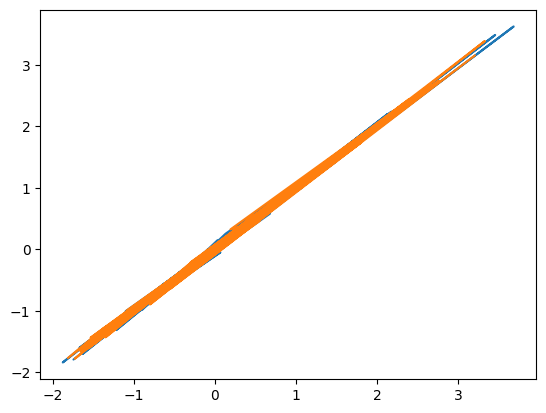

In [12]:
plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,0],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,0])

plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,1],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,1])

## STRAND

In [5]:
from main import *
m = bi(platform='cpu')
import json
import jax.numpy as jnp
with open('OUTPUT STRAND.json', 'r') as f:
    data = json.load(f)
data.keys()
print("N_networktypes: ")
print(data['N_networktypes'])
print("N_id : ")
print(data['N_id'])
print("N_responses : ")
print(data['N_responses'])
print("N_periods : ")
print(data['N_periods'])
print("N_periods : ")
print(data['N_periods'])
print("N_individual_predictors : " )
print(data['N_individual_predictors'])
print("N_dyadic_predictors : ")
print(data['N_dyadic_predictors'])
print("flows : ")
print(data['flows'])
data['individual_predictors'] = jnp.array([item['Mass'] for item in data['individual_predictors']])
print("individual_predictors : ")
print(data['individual_predictors'])
#print("N_block_predictors : ")
#print(data['N_block_predictors'])
#print("N_groups_per_block_type : ")
#print(data['N_groups_per_block_type'])
#print("outcome_mode : ")
#print(data['outcome_mode'] )
#data['block_predictors'] = jnp.array([item['Merica'] for item in data['block_predictors']])
print("block_predictors : ")
print(data['block_predictors'] )
print("outcome_mode : ")
print(data['outcome_mode'] )

Kinship = jnp.array(data['dyadic_predictors']['Kinship'])
print(Kinship.shape)
Dominant = jnp.array(data['dyadic_predictors']['Dominant'])
print(Dominant.shape)
exposure = jnp.array(data['exposure'])[:,:,1]
print(exposure.shape)

# Matrices to edgelist
result_dom = bi.net.mat_to_edgl(Dominant)
result_dom.shape
result_kin = bi.net.mat_to_edgl(Kinship)
result_kin
data['outcomes'] = jnp.array(data['outcomes'])
result_outcomes = bi.net.mat_to_edgl(data['outcomes'][:,:,0])
print(result_outcomes.shape)

N_id = data['individual_predictors'].shape[0]
print((N_id*(N_id-1))/2)
focal_individual_predictors = data['individual_predictors']
target_individual_predictors = data['individual_predictors']


c:\Users\SSosa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


jax.local_device_count 16
N_networktypes: 
[1]
N_id : 
[100]
N_responses : 
[1]
N_periods : 
[0]
N_periods : 
[0]
N_individual_predictors : 
[1]
N_dyadic_predictors : 
[2]
flows : 
[0]
individual_predictors : 
[0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0
 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0
 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
block_predictors : 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outcome_mode : 
[3]
(100, 100)
(100, 100)
(100, 100)
(4950, 2)
4950.0


### Model

In [6]:
# Building model and sampling it ------------------
d_s, d_r = bi.net.prerpare_dyadic_effect(Kinship)
@jit
def logit(x):
    return jnp.log(x / (1 - x))

def model(N_id, result_outcomes,d_s, d_r, focal_individual_predictors, target_individual_predictors, outcome_mode, exposure):
    # Block ---------------------------------------
    B = bi.dist.normal(logit(0.1/jnp.sqrt(N_id)), 2.5, shape=(1,), name = 'block')

    ## SR ---------------------------------------
    sr_terms, focal_effects, target_effects = bi.net.nodes_terms(1, 
                                                          focal_individual_predictors, 
                                                          target_individual_predictors)
    sr_rf, sr_raw, sr_sigma, sr_L = bi.net.nodes_random_effects(sr_terms.shape[0])

    sr = bi.net.vec_node_to_edgle(sr_terms + sr_rf)
  
    # Dyadic--------------------------------------  
    dr_terms, dyad_effects = bi.net.dyadic_terms(d_s, d_r)
    rf, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(dr_terms.shape[0])
    dr = dr_terms + rf

    # Likelihood
    if outcome_mode == 1:
        lk('Y', Poisson(B[0] + sr + dr), obs=result_outcomes)

    elif outcome_mode == 2:
        lk('Y', Binomial(total_count = exposure, logits= B[0] + sr + dr), obs=result_outcomes)
        
    elif outcome_mode == 3:
        lk('Y', Poisson(jnp.exp(B[0] + sr + dr)), obs=result_outcomes)

dat = dict(
    N_id = N_id,
    result_outcomes = result_outcomes,
    d_s = d_s, d_r = d_r,
    focal_individual_predictors = focal_individual_predictors,
    target_individual_predictors = target_individual_predictors,
    outcome_mode = int(3),
    exposure = bi.net.mat_to_edgl(exposure)
)
m = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m.run(random.PRNGKey(0), **dat)
res = az.from_numpyro(m)

sample: 100%|██████████| 1000/1000 [05:28<00:00,  3.04it/s, 511 steps of size 7.87e-03. acc. prob=0.93]


In [74]:
from jax import jit
from main import *
from functools import partial
import time as tm
from numpyro.handlers import mask, trace
output = data['outcomes'][:,:,0]
#output = output.at[jnp.diag_indices(output.shape[0])].set(-1)

@jit
def remove_diagonal(arr):
    n = arr.shape[0]
    if arr.shape[0] != arr.shape[1]:
        raise ValueError("Array must be square to remove the diagonal.")
    
    # Create a mask for non-diagonal elements
    mask = ~np.eye(n, dtype=bool)
    
    # Apply the mask to the array to get non-diagonal elements
    non_diag_elements = arr[mask]  # Reshape as needed, here to an example shape
    
    return non_diag_elements

def model(N_id, result_outcomes, focal_individual_predictors, target_individual_predictors, Kinship):
    # Block ---------------------------------------
    B = dist.normal('block', logit(0.1/jnp.sqrt(N_id)), 2.5, sample_shape=[1,])

    # sr-----------------------------------------------------------------------------------
    sr_raw =  dist.normal('sr_raw', 0, 1, sample_shape=(N_id, 2))
    sr_sigma =  dist.exponential('sr_sigma', 1, sample_shape= (2,))
    sr_L = dist.lkjcholesky('sr_L', 2, 4)
    rf_sr = vmap(lambda x: factor.random_centered(sr_sigma, sr_L, x))(sr_raw)
    rf_receiver = numpyro.deterministic('rf_receiver', jnp.tile(rf_sr[:,0], (N_id,1)))
    rf_sender = numpyro.deterministic('rf_sender',jnp.tile(rf_sr[:,1], (N_id, 1)))
    
    sr_terms, focal_effects, target_effects = net.nodes_terms(1, 
                                                      focal_individual_predictors, 
                                                      target_individual_predictors)
    receiver_term = jnp.tile(sr_terms[:,0], (N_id,1))
    sender_term = jnp.tile(sr_terms[:,0], (N_id,1))

    # dr -----------------------------------------------------------------------------------
    dr_raw =  dist.normal('dr_raw', 0, 1, sample_shape=(int(N_id*(N_id-1)/2), 2))
    dr_sigma =  dist.exponential('dr_sigma', 1, sample_shape= (2,))
    dr_L = dist.lkjcholesky('dr_L', 2, 4)
    rf_dr = vmap(lambda x: factor.random_centered(dr_sigma, dr_L, x))(dr_raw)
    rf_dyad =  numpyro.deterministic('rf_dyad',net.edgl_to_mat(rf_dr, N_id))

    rf_receiver_noDiag = remove_diagonal(rf_receiver)
    rf_sender_noDiag  = remove_diagonal(rf_sender)
    rf_dyad_noDiag  = remove_diagonal(rf_dyad)
    Kinship_noDiag  = remove_diagonal(Kinship)
    result_outcomes_noDiag  = remove_diagonal(result_outcomes)
    receiver_term_noDiag  = remove_diagonal(receiver_term)
    sender_term_noDiag  = remove_diagonal(sender_term)

    lk('Y', Poisson(jnp.exp(1 + B[0] + rf_receiver_noDiag   +  receiver_term_noDiag + 
                            rf_sender_noDiag  + sender_term_noDiag + 
                            rf_dyad_noDiag )), obs=result_outcomes_noDiag )

dat = dict(
    N_id = N_id,
    result_outcomes = output,
    focal_individual_predictors = focal_individual_predictors,
    target_individual_predictors = target_individual_predictors,
    Kinship = Kinship
)

m2 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m2.run(random.PRNGKey(0), **dat)
res2 = az.from_numpyro(m2)
res2

sample: 100%|██████████| 1000/1000 [03:09<00:00,  5.29it/s, 1023 steps of size 5.62e-03. acc. prob=0.80]


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [84]:
print(jnp.mean(jnp.array(res['posterior']['focal_effects']), axis = 1)) #should be 1.032

[[1.0133038]]


In [85]:
print(jnp.mean(jnp.array(res['posterior']['target_effects']), axis = 1)) #should be 1.221

[[0.9150954]]


In [87]:
print(jnp.mean(jnp.array(res['posterior']['dyad_effects']), axis = 1)) # should be 0.907

[0.4284015]


In [86]:
print(jnp.mean(jnp.array(res['posterior']['block']), axis = 1)) # should be -2.92

[[-2.9872117]]


### STAN comparaison

In [132]:
import numpy as np
ones_column = np.ones((len(data["individual_predictors"]), 1))

# Reshape the vector to be a column vector
vector_column = data["individual_predictors"].reshape(-1, 1)

# Concatenate the two columns horizontally
focal_set = np.concatenate((ones_column, vector_column), axis=1)

Kinship = jnp.array(data['dyadic_predictors']['Kinship'])
print(Kinship.shape)
Kinship = jnp.array(data['dyadic_predictors']['Kinship'])
# Get the shape of the existing array
shape = Kinship.shape

# Create a new array with the same shape, filled with 1's
ones_array = jnp.ones(shape, dtype=int)
ones_array

d = [
    [-3.00, 1.5],
    [ 3.00, 1.5],
    [-1.50, 1.0],
    [ 1.00, 0.0],
    [ 1.00, 0.0],
    [ 1.00, 0.0],
    [ 0.00, 1.0],
    [ 0.00, 1.0],
    [ 0.00, 1.0],
    [ 0.10, 2.5],
    [ 0.01, 2.5],
    [ 0.00, 1.0],
    [ 0.00, 1.0],
    [ 0.00, 1.0],
    [ 1.00, 0.0],
    [ 1.00, 0.0],
    [ 2.50, 0.0],
    [ 2.50, 0.0],
    [ 1.50, 0.0],
    [ 3.00, 1.0],
    [ 2.00, 0.0],
    [ 3.00, 12.0]
]

# Convert the list to a JAX array
priors = jnp.array(d)


(100, 100)


In [133]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code = """
data{                                           
    int N_id;                                                                                                            
    int N_responses;        

    array[3] int N_params;                                          
                                             
    array[N_id,N_id,N_responses] int outcomes;  
    array[N_id,N_id,N_responses] int exposure;                              

    matrix[N_id, N_params[1]] focal_set;
    matrix[N_id, N_params[2]] target_set;

    array[N_id, N_id, N_params[3]] real dyad_set;

    matrix [22, 2] priors;
    
    int export_network;
    int outcome_mode;                           
}

transformed data{
 matrix[N_id, N_params[1]-1] focal_individual_predictors; 
 matrix[N_id, N_params[2]-1] target_individual_predictors; 

 array[N_id, N_id, N_params[3]-1] real dyad_individual_predictors; 

//# Make pruned data
  
  if(N_params[1]>1){
  for(i in 2:N_params[1]){
  focal_individual_predictors[ , i-1] = focal_set[,i];  
   }}

  if(N_params[2]>1){
  for(i in 2:N_params[2]){
  target_individual_predictors[ , i-1] = target_set[,i];  
   }}

  if(N_params[3]>1){
  for(i in 2:N_params[3]){
  dyad_individual_predictors[ , , i-1] = dyad_set[,,i];  
   }}
}

parameters{
    //########################################################### Latent Netowrk
    matrix[1,1] B;

    vector<lower=0>[2] sr_sigma;  //# Variation of sender-receiver effects
    cholesky_factor_corr[2] sr_L;
    array[N_id] vector[2] sr_raw;

    real<lower=0> dr_sigma;     //# Variation of dyadic effects
    cholesky_factor_corr[2] dr_L;
    matrix[N_id, N_id] dr_raw;

    //# Effects of covariate
    vector[N_params[1]-1] focal_effects;
    vector[N_params[2]-1] target_effects;
    vector[N_params[3]-1] dyad_effects;  
}

model{
  array[N_id] vector[2] sr;
  matrix[N_id, N_id] dr;

  vector[2] scrap;

    //# Priors on effects of covariates
     focal_effects ~ normal(priors[12,1], priors[12,2]);
     target_effects ~ normal(priors[13,1], priors[13,2]);
     dyad_effects ~ normal(priors[14,1], priors[14,2]);

    //# Sender-receiver priors for social relations model
    for(i in 1:N_id)
    sr_raw[i] ~ normal(0,1);

    sr_sigma ~ exponential(priors[15,1]);    
    sr_L ~ lkj_corr_cholesky(priors[17,1]);

    for(i in 1:N_id){
     vector[2] sr_terms;

     sr_terms[1] = dot_product(focal_effects,  to_vector(focal_individual_predictors[i]));
     sr_terms[2] = dot_product(target_effects,  to_vector(target_individual_predictors[i]));  

     sr[i] = diag_pre_multiply(sr_sigma, sr_L) * sr_raw[i] + sr_terms;
     }

    //# Dyadic priors for social relations model
    to_vector(dr_raw) ~ normal(0,1);
    dr_sigma ~ exponential(priors[16,1]);
    dr_L ~ lkj_corr_cholesky(priors[18,1]);

    for(i in 1:(N_id-1)){
    for(j in (i+1):N_id){
     scrap[1] = dr_raw[i,j];
     scrap[2] = dr_raw[j,i];
     scrap = rep_vector(dr_sigma, 2) .* (dr_L*scrap);
     dr[i,j] = scrap[1] + dot_product(dyad_effects,  to_vector(dyad_individual_predictors[i, j, ]));
     dr[j,i] = scrap[2] + dot_product(dyad_effects,  to_vector(dyad_individual_predictors[j, i, ]));
     }
     }

    for(i in 1:N_id){
     dr[i,i] = -99; //# ignore this :)
    }

    //# priors for 
    B[1,1] ~ normal(logit(priors[10,1]/sqrt(N_id)), priors[10,2]);


    //# likelihood
    for ( i in 1:N_id ) {
     for ( j in 1:N_id ) {
       if ( i != j ) {

      if(outcome_mode==1){
      outcomes[i,j,1] ~ bernoulli_logit(B[1,1] + sr[i,1] + sr[j,2] + dr[i,j]);  //# Then model the outcomes
       }
      if(outcome_mode==2){
      outcomes[i,j,1] ~ binomial_logit(exposure[i,j,1], B[1,1] + sr[i,1] + sr[j,2] + dr[i,j]);  //# Then model the outcomes
       }
      if(outcome_mode==3){
      outcomes[i,j,1] ~ poisson_log(B[1,1] + sr[i,1] + sr[j,2] + dr[i,j]);  //# Then model the outcomes
       }

       }
      }
     }


 }


generated quantities{
    //# compute posterior prob of each network tie
    matrix[N_id*export_network, N_id*export_network] p;
    array[N_id*export_network] vector[2*export_network] sr;
    matrix[N_id*export_network, N_id*export_network] dr;
 
    if(export_network==1){                
     vector[2] terms;
     int tie;
     vector[2] scrap;
            
    for(i in 1:N_id){
     vector[2] sr_terms;

     sr_terms[1] = dot_product(focal_effects,  to_vector(focal_individual_predictors[i]));
     sr_terms[2] = dot_product(target_effects,  to_vector(target_individual_predictors[i]));  

     sr[i] = diag_pre_multiply(sr_sigma, sr_L) * sr_raw[i] + sr_terms;
     }

    for(i in 1:(N_id-1)){
    for(j in (i+1):N_id){
     scrap[1] = dr_raw[i,j];
     scrap[2] = dr_raw[j,i];
     scrap = rep_vector(dr_sigma, 2) .* (dr_L*scrap);
     dr[i,j] = scrap[1] + dot_product(dyad_effects,  to_vector(dyad_individual_predictors[i, j, ])) + B[1, 1];
     dr[j,i] = scrap[2] + dot_product(dyad_effects,  to_vector(dyad_individual_predictors[j, i, ])) + B[1, 1];
    }
    }

    for(i in 1:N_id){
     dr[i,i] = -99; //# ignore this :)
    }


    for ( i in 1:N_id ) {
        for ( j in 1:N_id ) {
            if ( i != j ) {
      // consider each possible state of true tie and compute prob of data
      if(outcome_mode==1){
       p[i,j] = inv_logit( sr[i,1] + sr[j,2] + dr[i,j]);
       }
      if(outcome_mode==2){
       p[i,j] = inv_logit( sr[i,1] + sr[j,2] + dr[i,j]);
       }
      if(outcome_mode==3){
       p[i,j] = exp(sr[i,1] + sr[j,2] + dr[i,j]);  
       }
            }
        }//j
    }//i

  for ( i in 1:N_id ) {
   p[i,i] = 0; 
   }
 }
}
"""
d = {
    "N_id": int(100), # N id
    "N_responses" : int(1), #outcome
    "N_params": np.array([2,2,2]),


    "outcomes": np.array(data["outcomes"]),
    "exposure":  np.array(data["exposure"]),

    "focal_set":  np.array(focal_set),
    "target_set":  np.array(focal_set),

    "dyad_set":  np.array(jnp.stack((ones_array, Kinship), axis=2)),
    "priors":  np.array(priors),
    "outcome_mode": int(3),
    "export_network": int(0),
}
start = tm.time()
stan_model = stan.build(stan_code, data = d)
fit = stan_model.sample(num_chains=4, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%/usr/lib/python3.10/multiprocessing/pope

Pystan took: 2829.3684 seconds


In [140]:
print('BI:')
print(jnp.mean(jnp.array(res['posterior']['block']), axis = 1))
print('STRAND:')
print(df['B.1.1'].mean())

BI:
[[-2.9872117]]
STRAND:
-3.6132003231679026


In [141]:
print('BI:')
print(jnp.mean(jnp.array(res['posterior']['sr_sigma']), axis = 1))
print('STRAND:')
print(df['sr_sigma.1'].mean())
print(df['sr_sigma.2'].mean())

BI:
[[1.722374  1.7247385]]
STRAND:
2.0181002996525508
1.8183903048367855


In [143]:
print('BI:')
print(jnp.mean(jnp.array(res['posterior']['target_effects']), axis = 1))
print('STRAND:')
print(df['target_effects.1'].mean())

BI:
[[0.9150954]]
STRAND:
1.14783753491008


In [144]:
print('BI:')
print(jnp.mean(jnp.array(res['posterior']['focal_effects']), axis = 1))
print('STRAND:')
print(df['focal_effects.1'].mean())

BI:
[[1.0133038]]
STRAND:
1.6536600650462456


In [145]:
print('BI:')
print(jnp.mean(jnp.array(res['posterior']['dyad_effects']), axis = 1))
print('STRAND:')
print(df['dyad_effects.1'].mean())

BI:
[0.4284015]
STRAND:
0.7759656424249831


## BISONR

In [3]:
df = pd.read_csv('bison sim data.csv')
df.shape

(45, 7)

### Binary

In [4]:
num_rows = df.shape[0] 
N_id = len(jnp.unique(jnp.stack([jnp.array(df.node_1_id.values), jnp.array(df.node_2_id.values)]).flatten()))
N_dyads = jnp.arange(0,(N_id*(N_id-1))/2)
num_edges = len(N_dyads)

num_fixed = 0 # Number of fixed effect parameters
num_random = 0 # Number of random effect parameters
num_random_groups = 0 # Number of random effect groups

event = jnp.array(df.event.values) # Outcome for each data point (presence/absence)
divisor = jnp.array(df.duration.values) # Duration of each observation
dyad_ids = jnp.arange(0,(N_id*(N_id-1))/2, dtype= jnp.int32)  # Dyad IDs of each observation for indexing edge weights

design_fixed = 0 # Design matrix for fixed effects
design_random = 0 # Design matrix for random effects.
random_group_index = 0 # Index for groupings for random effects


prior_edge_mu = 0 #  Prior mean for fixed effects
prior_edge_sigma  =  2.5 #  Prior standard deviation for fixed effects
prior_fixed_mu  = 0 #  Prior mean for fixed effects
prior_fixed_sigma  = 2.5 #  Prior standard deviation for fixed effects
prior_random_mean_mu  = 0 #  Prior mean on centralisation of random effects
prior_random_mean_sigma  = 1 #  Prior standard deviation on centralisation of random effects
prior_random_std_sigma  = 1 #  Prior standard deviation on dispersion of random effects
prior_zero_prob_alpha  = 1 #  Prior alpha on zero inflation
prior_zero_prob_beta  = 1 #  Prior beta on zero inflation
priors_only  = 0 # Whether to sample from only the priors
partial_pooling  = 0 # Whether to pool edge weight estimates
zero_inflated  = False # Whether to use zero-inflated edge model

edge_weight = jnp.zeros((num_edges,)) # Parameters for edge weights.
beta_fixed = jnp.zeros((num_fixed,)) # Parameters for fixed effects.
beta_random = jnp.zeros((num_random,)) # Parameters for random effects.
random_group_mu = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (mean).
random_group_sigma = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (std. dev.).
edge_sigma = jnp.zeros((partial_pooling,)) # Random effect for edge weight pooling.
#zero_prob = jnp.zeros((zero_inflated,)) # Zero inflated parameter for probability of zeroes.
if zero_inflated:
    zero_prob = 0
else :
    zero_prob = 0.5

In [5]:
predictor = jnp.ones((num_rows,)) + edge_weight[dyad_ids] + jnp.repeat(0, num_rows) + jnp.repeat(0, num_rows) 
#design_fixed * beta_fixed
#design_random * beta_random

In [9]:
zero_prob = numpyro.distributions.Beta(1.0, 1.0)
predictor = jnp.ones(event.shape)
prob = jax.nn.sigmoid(predictor)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Binomial(total_count=divisor, probs=prob), 
    gate=0.51848227
), obs=event)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Poisson(rate=event/divisor), 
    gate=0.51848227
), obs=event)


Array([3, 0, 3, 4, 2, 3, 1, 5, 3, 0, 2, 3, 3, 1, 0, 0, 0, 2, 1, 2, 1, 3,
       5, 3, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 5, 3,
       1], dtype=int32)

In [ ]:
import jax.scipy as jsp
if zero_inflated:
    event = bi.dist.binomial(divisor, jax.nn.sigmoid(predictor))
else:
    inv_logit_predictor = jax.nn.sigmoid(predictor)
    log_binomial = jsp.stats.binom.logpmf(event, divisor, inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_binomial
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_binomial])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Count

In [ ]:
import jax.scipy as jsp

if zero_inflated == 0:
    event = bi.dist.poisson(jnp.exp(predictor) * divisor)
else:
    exp_predictor = jnp.exp(predictor)
    log_poisson = jsp.stats.poisson.logpmf(event, divisor, exp_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_poisson
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_poisson])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Duration

In [ ]:
import jax.scipy as jsp
edge_weight_cov = bi.lkjcholesky(2,2, sample = True)
event_count = jnp.array((num_edges,))  # Outcome for each data point (presence/absence)
dyad_ids_receiver = jnp.array((num_rows,))   # Dyad ID for receiver if using sender/receiver effects
prior_rate_sigma = 1 #Prior on standard deviation of event rate
sender_receiver = 1 #Whether to use sender-receiver effects
rate = jnp.array((num_edges,))
sender_receiver_cov = jnp.array((sender_receiver,))
inv_logit_predictor = jax.nn.sigmoid(predictor)

if zero_inflated == 0:
    event = bi.dist.exponential(rate[dyad_ids] / inv_logit_predictor)
    event_count = bi.dist.poisson(rate * divisor)

else:
    exp_predictor = jnp.exp(predictor)    
    log_exponential = jsp.stats.expon.logpmf(event, rate[dyad_ids], inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_exponential
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_exponential])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    rate = bi.dist.normal(0, prior_rate_sigma, sample = True)
    if partial_pooling == 0:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #}
        else:
            edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma)
    else:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #} 
        else:       
            edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
    
    edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

## NBDA

## Multiplexe

# Dirichlet Multinomial with centered random factors

In [103]:
import seaborn as sns
import numpy as np
from jax import random
from jax.nn import softmax
import jax.numpy as jnp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

###############################################################################
############ SIMULATING MULTINOMIAL DATA WITH SOFTMAX LINK FUNCTION ###########
def mysoftmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x, axis=0)

K = 3
N = 100
N_obs = 2
sigma_random = 0.6


########################################################
################### Fixed effect Sim ###################
#a = np.random.normal(0, 1, K)
a = np.array([3,1,1]) # Forcing a values


# Factors--------------------------
NY = 4
NV = 8

Y2 = np.full((NV, NY), np.nan) 
means = np.random.normal(0, 1, NY)
offsets = np.random.normal(0, 1, NV)
for i in range(NV):
  for k in range(NY):
    Y2[i,k] = means[k] + offsets[i]

    
b_individual = np.random.normal(0, 1, (N, K))
mu = b_individual + a


# Declare an empty Matrix to fill with data
Y = np.empty((N * N_obs, K))

# Declare an empty vector to fill with IDs
id = []

# Loop over each individual
for i in range(N):
    # Simulate N_obs draws from the multinomial
    Y[i*N_obs:(i+1)*N_obs, :] = np.apply_along_axis(lambda x: np.random.multinomial(100, mysoftmax(x)), 0, mu[i])
    # Assign ID vector
    id += [i] * N_obs


N = N*N_obs
K = K
ni = N
y = jnp.array(Y, dtype=jnp.int32).reshape(N, K)
i_ID = jnp.array(id)

dat = dict(
    K = K,
    ni = ni,
    y = y,
    i_ID = i_ID
)

## Latent variable model

In [104]:
init_key, sample_key = random.split(random.PRNGKey(0))
init_key = jnp.array(init_key)
init_key

Array([4146024105,  967050713], dtype=uint32)

In [105]:
import pandas as pd 
import math
import os
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import Image, set_matplotlib_formats
from matplotlib.patches import Ellipse, transforms
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import expit

import numpy as onp
import numpyro as numpyro

import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size, print_summary
from numpyro.infer import MCMC, NUTS
numpyro.set_platform("cpu")
numpyro.set_host_device_count(30)


# Simulation ---------------
NY = 4
NV = 8

Y2 = np.full((NV, NY), np.nan) 
means = np.random.normal(0, 1, NY)
offsets = np.random.normal(0, 1, NV)
for i in range(NV):
  for k in range(NY):
    Y2[i,k] = means[k] + offsets[i]

b_individual = np.random.normal(0, 1, (N, K))
mu = b_individual + a

Y2 = jnp.array(Y2)



In [106]:

# Building model and sampling it ------------------
def model(NY, NV, Y2):
    means =  numpyro.sample('means', numpyro.distributions.Normal(0,1).expand([NY]))
    offset =  numpyro.sample('offset', numpyro.distributions.Normal(0,1).expand([NV,1]))
    sigma =  numpyro.sample('sigma', numpyro.distributions.Exponential(1).expand([NY])) 
    tmp = jnp.tile(means, (NV, 1)).reshape(NV,NY)  
    mu_l = tmp + offset 
    numpyro.sample('Y2', numpyro.distributions.Normal(mu_l, jnp.tile(sigma, [NV, 1])), obs=Y2)

dat = dict(
    NY = NY,
    NV = NV,
    Y2 = Y2
)
m = MCMC(NUTS(model, init_strategy = numpyro.infer.init_to_median()), num_warmup=1000, num_samples=1000, num_chains=1)
m.run(random.PRNGKey(0), extra_fields=["diverging"], **dat)

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1386.84it/s, 1023 steps of size 1.50e-07. acc. prob=0.79]


In [31]:
import arviz as az
data = az.from_numpyro(m)
az.summary(data)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],0.519,0.0,0.519,0.519,0.0,0.0,1000.0,1000.0,NaN
means[1],0.191,0.0,0.191,0.191,0.0,0.0,1000.0,1000.0,NaN
means[2],0.657,0.0,0.657,0.657,0.0,0.0,1000.0,1000.0,NaN
means[3],-0.613,0.0,-0.613,-0.613,0.0,0.0,1000.0,1000.0,NaN
"offset[0, 0]",0.530,0.0,0.530,0.530,0.0,0.0,1000.0,1000.0,NaN
"offset[1, 0]",0.812,0.0,0.812,0.812,0.0,0.0,1000.0,1000.0,NaN
"offset[2, 0]",-0.366,0.0,-0.366,-0.366,0.0,0.0,1000.0,1000.0,NaN
"offset[3, 0]",2.077,0.0,2.077,2.077,0.0,0.0,1000.0,1000.0,NaN
"offset[4, 0]",0.988,0.0,0.988,0.988,0.0,0.0,1000.0,1000.0,NaN
"offset[5, 0]",0.342,0.0,0.342,0.342,0.0,0.0,1000.0,1000.0,NaN


In [32]:
means

array([1.28912305, 0.96183663, 1.42779941, 0.15728591])

## Random centered effects

In [107]:
@jit
def random_centered(sigma, cor_mat, offset_mat):
    """Generate the centered matrix of random factors 

    Args:
        sigma (vector): Prior, vector of length N
        cor_mat (2D array): correlation matrix, cholesky_factor_corr of dim N, N
        offset_mat (2D array): matrix of offsets, matrix of dim N*k

    Returns:
        _type_: 2D array
    """
    return jnp.dot(diag_pre_multiply(sigma, cor_mat), offset_mat)

In [ ]:
def model(K, ni, y, i_ID):
    a = normal('a', [K], 0,1)
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 1) # Implies a uniform distribution over correlation matrices
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha = random_centered(Sigma_individual, L_individual, z_individual)
    lk = jnp.exp(a + alpha[i_ID])
    sample("y", DirichletMultinomial(lk, int(100)), obs=y)

m = bi()
m.data = dat
m.run(model, init_strategy = numpyro.infer.init_to_median(), 
      num_warmup=500, num_samples=500, num_chains=1)


In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(a))) 
print('Numpypro estimation:')
print(jax.nn.softmax(jnp.mean(jnp.array(m.trace['posterior']['a'][0]), axis = 0)))

Simulated:
[0.786986   0.10650697 0.10650697]
Numpypro estimation:
[0.7328625  0.13674371 0.13039377]


In [ ]:
def model(K, ni, y, i_ID):
    a = normal('a', [K], 0,1)
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 1) # Implies a uniform distribution over correlation matrices
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha = random_centered2(Sigma_individual, L_individual, z_individual)
    lk = jnp.exp(a + alpha[i_ID])
    sample("y", DirichletMultinomial(lk, int(100)), obs=y)

m = bi()
m.data = dat
m.run(model, init_strategy = numpyro.infer.init_to_median(), 
      num_warmup=500, num_samples=500, num_chains=1)

In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(a))) 
print('Numpypro estimation:')
print(jax.nn.softmax(jnp.mean(jnp.array(m.trace['posterior']['a'][0]), axis = 0)))

Simulated:
[0.786986   0.10650697 0.10650697]
Numpypro estimation:
[0.66280484 0.1774538  0.15974137]


In [ ]:
def model(K, ni, y, i_ID):
    a = normal('a', [K], 0,1)
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 1) # Implies a uniform distribution over correlation matrices
    print(L_individual.shape)
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha = ((Sigma_individual[..., None] * L_individual) @ z_individual)
    print(alpha.shape)
    lk = jnp.exp(a + alpha[i_ID])
    sample("y", DirichletMultinomial(lk, int(100)), obs=y)

m = bi()
m.data = dat
m.run(model, init_strategy = numpyro.infer.init_to_median(), 
      num_warmup=500, num_samples=500, num_chains=1, chain_method='vectorized')

In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(a))) 
print('Numpypro estimation:')
print(jax.nn.softmax(jnp.mean(jnp.array(m.trace['posterior']['a'][0]), axis = 0)))

Simulated:
[0.786986   0.10650697 0.10650697]
Numpypro estimation:


AttributeError: 'bi' object has no attribute 'trace'

In [ ]:
###############################################################################
#################################### Pustan Model  #############################
import time as tm
import stan
import nest_asyncio
import numpy as np
tmp = dat
tmp['y'] = np.array(tmp['y'])
tmp['i_ID'] = np.array(tmp['i_ID']+1)
tmp['ni'] = tmp['ni']
tmp['K'] = tmp['K']
tmp['N'] = int(N)

nest_asyncio.apply()
stan_code = """ 
data {
    int<lower=0>  N;             // number of observations
    int<lower=0>  K;             // number of occupations
    int ni;                     // NUmber of Unique Individauls
    array[N, K] int y;           // array of observed occupation indicators
    array[N]int<lower=0>  i_ID;     // village indicator for each individual
}
parameters {
    vector[K] a;                    // intercept for each occupation
    matrix[ni, K]  z_individual;    // raw random effect for household 
    cholesky_factor_corr[ni] L_individual; // Cholesky factor for 
    vector<lower=0>[ni] Sigma_individual;

}
transformed parameters{
    matrix[ni, K] b_individual;
    b_individual = diag_pre_multiply(Sigma_individual, L_individual) * z_individual;
}
model{
    array[N] vector[K] p;
    matrix[N, K] random_effects;
    to_vector(a) ~ normal(0, 1);
    L_individual ~   lkj_corr_cholesky(2);
    Sigma_individual ~ exponential(1);
    to_vector(z_individual) ~ normal(0, 1);
    // Likelihood for
    for (k in 1:K) {
        for (i in 1:N) {
          random_effects[i, k] = b_individual[i_ID[i], k];
          p[i,k] =  a[k] + random_effects[i, k];
      }
    }
    for (i in 1:(N)) {
        y[i,] ~ dirichlet_multinomial(exp(p[i,]));
    }
}
"""

start = tm.time()
stan_model = stan.build(stan_code, data = tmp)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500, init = [{'L_individual': np.zeros((tmp['ni'], tmp['ni']))}])
end = tm.time()    
#df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: found in cache, done.Sampling:   0%/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Sampling:   0% (1/1000)
Sampling:  10% (100/1000)
Sampling:  20% (200/1000)
Sampling:  30% (300/1000)
Sampling:  40% (400/1000)
Sampling:  50% (500/1000)
Sampling:  50% (501/1000)
Sampling:  60% (600/1000)
Sampling:  70% (700/1000)
Sampling:  80% (800/1000)
Sampling:  90% (900/1000)
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 0.006054 seconds
  1000 transitions using 10 leapfrog steps per transition would take 60.54 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lkj_corr_cholesky_lpdf: Random variable[6] is 0

Pystan took: 432.2593 seconds


In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(np.array([3,1,1])))) 
print('Estimation Multinomial:')
post = m.sampler.get_samples()
print(jax.nn.softmax(jnp.mean(post['a'], axis = 0)))
print('Estimation DirichletMultinomial:')
#post = m2.sampler.get_samples()
#print(jax.nn.softmax(jnp.mean(post['a'], axis = 0)))
df = fit.to_frame()
print('Pytstan estimation')
print(jax.nn.softmax(jnp.array([df['a.1'].mean(),df['a.2'].mean(),df['a.3'].mean()])))

Simulated:
[0.786986   0.10650697 0.10650697]
Estimation Multinomial:
[0.79368174 0.11202765 0.0942907 ]
Estimation DirichletMultinomial:
Pytstan estimation
[0.7914235  0.11247264 0.09610377]


## Gaussian process

In [2]:
from Mutils import Mgaussian, cov_GPL2
from jax.scipy.stats import norm
gaus = Mgaussian()

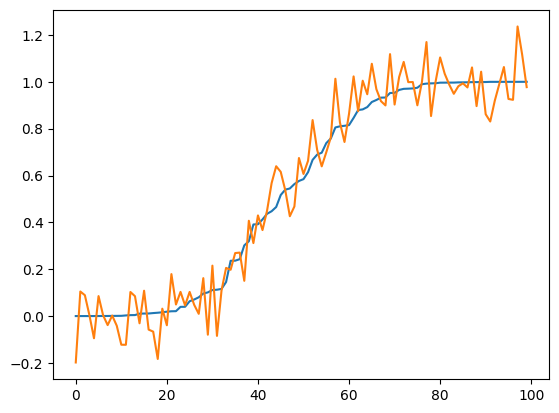

In [3]:
raw = sample.uniform(-4,4, sample_shape=(100,))
raw  = jnp.sort(raw)
sequence = jnp.array([i for i in range(1, 11) for _ in range(10)])
unique = jnp.unique(jnp.array(sequence))
result = []

for i in range(0,len(unique)):  
    result.append(jnp.mean(raw[jnp.where(sequence==(i + 1))], axis = 0))

Dmat = gaus.distance_matrix(jnp.array(result))
cdf_value = norm.cdf(raw , loc=0, scale=1)# to plot for after
plt.plot(jnp.arange(0, 100), cdf_value)
error = sample.normal(0, 0.1, sample_shape=(100,))
y = cdf_value + error
plt.plot(jnp.arange(0, 100), y)

In [7]:
def gaussian_process(Dmat, etasq, rhosq, sigmaq):
    SIGMA = cov_GPL2(Dmat, etasq, rhosq, sigmaq)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = sample.normal(0, 1, sample_shape= (10,))
    k = numpyro.deterministic("k", (L_SIGMA @ z[..., None])[..., 0])
    return k

In [9]:
# Perform gaussain process through array of Nx3
a = sample.normal(0,1, (8, 20))
sigma = sample.exponential(1, sample_shape=(8*20,))
etasq = sample.exponential(2, sample_shape=(8*20,))
rhosq = sample.exponential(0.5, sample_shape=(8*20,))
sigmaq = sample.exponential(2, sample_shape= (8*20,))
tmp = jnp.stack([etasq, rhosq, sigmaq], axis = 1)
t = vmap(lambda x: gaussian_process(Dmat, x[0], x[1], x[2]))(tmp) # need to return 8 * 20 * 10
t.shape

(160, 10)

In [188]:
def gaus_model(Dmat, y ,sequence):
    a = dist.normal('a', 0,1)
    sigma = dist.exponential('s', 1)
    etasq = dist.exponential("etasq",2)
    rhosq = dist.exponential("rhosq",0.5)
    sigmaq = dist.exponential("sigmaq",2)

    SIGMA = cov_GPL2(Dmat, etasq, rhosq, sigmaq)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = dist.normal('z', 0, 1, sample_shape= [10])
    k = numpyro.deterministic("k", (L_SIGMA @ z[..., None])[..., 0])
    
    mu = a + k[sequence]

    lk('Y', Normal(mu, sigma), obs=y)

dat = dict(
    Dmat = Dmat,
    y = y,
    sequence = sequence - 1 
)

m = MCMC(NUTS(gaus_model), num_warmup=500, num_samples=500, num_chains=1)
m.run(random.PRNGKey(0), **dat)
res = az.from_numpyro(m)


sample: 100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s, 191 steps of size 2.40e-02. acc. prob=0.92]


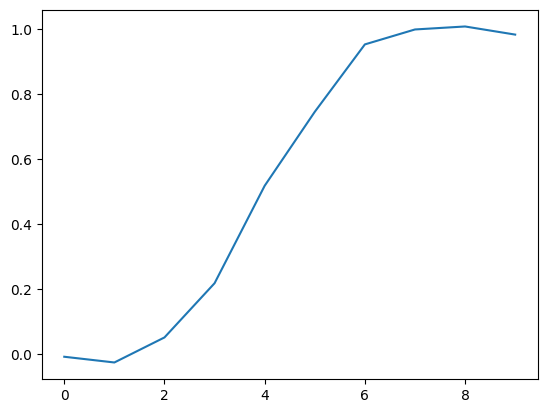

In [192]:
plt.plot(jnp.arange(0,10), jnp.mean(jnp.array(res['posterior']['a'])) + jnp.mean(jnp.array(res['posterior']['k'][0,:,:]), axis = 0))

## Combine latent, random and gaussian

In [485]:
# latent + random = random + latent[village[i]] with village being village ID
# gaussian simulation 
# 1. non linear function to generate gaussian proces for each parameters
# model 2 = random + latent[village[i]] + gaussian_process
# model 3  = model 2 + interaction effect
#interaction effect = non linear function where input is hhmembers[i]*offsets[vilage[i]] with new coefficients params
# Within model we need to change offset ouput as an integer so we do bxi*hhmembers[i]*offset[v_ID[i]]+ bxIsq*(hhmembers[i]*offset[v_ID[i]])


# Model on real data

In [486]:
def model(K, ni, y, i_ID):
    #individual 
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 50)
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha_individual = random_centered2(Sigma_individual, L_individual, z_individual)

    #household 
    Sigma_household = exponential('Sigma_household', [ni], 1 )
    L_household = lkjcholesky('L_household', [], ni, 50)
    z_household = normal('z_household', [ni,K], 0, 1)
    alpha_household = random_centered2(Sigma_household, L_household, z_household)

    #village 
    Sigma_village = exponential('Sigma_village', [ni], 1 )
    L_village = lkjcholesky('L_village', [], ni, 50)
    z_village = normal('z_village', [ni,K], 0, 1)
    alpha_village = random_centered2(Sigma_village, L_village, z_village)

    #LK
    random_factors = alpha_individual[i_ID] + alpha_household[i_ID] + alpha_village[i_ID]
    numpyro.sample("y", dist.DirichletMultinomial(a + random_factors[i_ID], int(12083)), obs=y)

# Model to latex

In [69]:
import re
from IPython.display import display, Latex
greek_symbols = {
    'alpha': '\\alpha',
    'beta': '\\beta',
    'gamma': '\\gamma',
    'delta': '\\delta',
    'epsilon': '\\epsilon',
    'zeta': '\\zeta',
    'eta': '\\eta',
    'theta': '\\theta',
    'iota': '\\iota',
    'kappa': '\\kappa',
    'lambda': '\\lambda',
    'mu': '\\mu',
    'nu': '\\nu',
    'xi': '\\xi',
    'omicron': 'o',  # No direct LaTeX symbol for omicron, using "o"
    'pi': '\\pi',
    'rho': '\\rho',
    'sigma': '\\sigma',
    'tau': '\\tau',
    'upsilon': '\\upsilon',
    'phi': '\\phi',
    'chi': '\\chi',
    'psi': '\\psi',
    'omega': '\\omega'
}

def convert_to_greek(var_name):
    # Convert variable name to lowercase for case-insensitive matching
    var_name_lower = var_name.lower()
    # Check if the variable name has a corresponding Greek symbol
    if var_name_lower in greek_symbols:
        return greek_symbols[var_name_lower]
    else:
        return var_name

def extract_latex(command):
    # Define a regular expression pattern to match the desired parts of the command
    pattern = r"(\w+)\s*=\s*(\w+)\([^,]+,\s*[^,]+,\s*(.*)\)"
    match = re.match(pattern, command)
    
    if match:
        var_name = match.group(1)
        func_name = match.group(2)
        params = match.group(3)
        # Convert var_name to Greek symbol if applicable
        var_name_latex = convert_to_greek(var_name)
        # Construct the desired LaTeX text
        latex_text = f"{var_name_latex} = {func_name}({params})"
        return latex_text
    else:
        return None

# Example usage
command = "Sigma_i = exponential('Sigma_individual', [ni], 1)"
latex_text = extract_latex(command)
display(Latex(f'''${latex_text}$'''))

<IPython.core.display.Latex object>

# Multiplex representation

## Network building

In [63]:
len(G1.nodes())

10

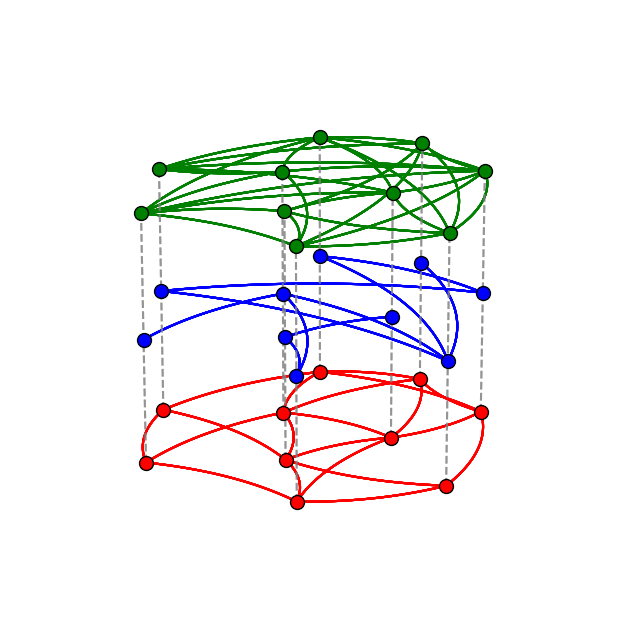

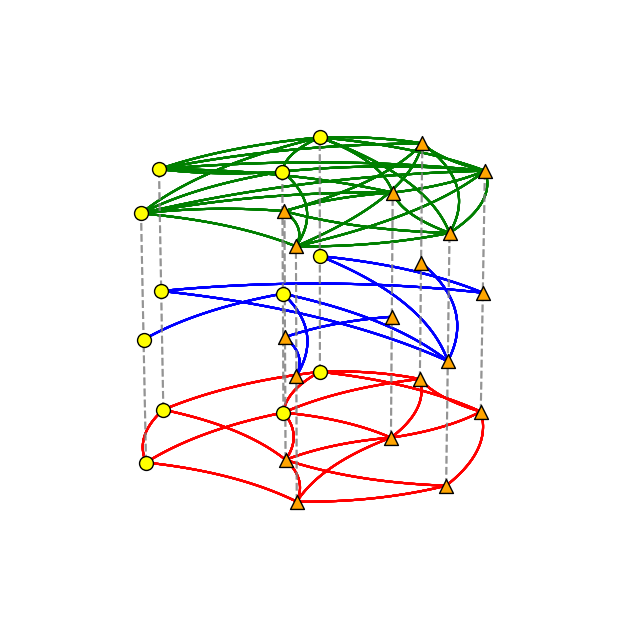

In [65]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Parameters: n = number of nodes, k = each node is connected to k nearest neighbors in ring topology, p = rewiring probability
n = 10  # Number of nodes
k1, k2, k3 = 4, 3, 6  # Each node is connected to different neighbors in different layers
p1, p2, p3 = 0.3, 0.6, 0.2  # Rewiring probabilities

# Generate Watts-Strogatz graphs for each layer
G1 = nx.watts_strogatz_graph(n, k1, p1)
G2 = nx.watts_strogatz_graph(n, k2, p2)
G3 = nx.watts_strogatz_graph(n, k3, p3)


# Function to plot a quadratic Bezier curve (slight curve)
def plot_curve(ax, p0, p1, p2, z_layer, color):
    t_vals = np.linspace(0, 1, 100)  # Parameter t values for interpolation
    curve_x = (1 - t_vals) ** 2 * p0[0] + 2 * (1 - t_vals) * t_vals * p1[0] + t_vals ** 2 * p2[0]
    curve_y = (1 - t_vals) ** 2 * p0[1] + 2 * (1 - t_vals) * t_vals * p1[1] + t_vals ** 2 * p2[1]
    curve_z = np.full_like(curve_x, z_layer)  # Keep z constant
    ax.plot(curve_x, curve_y, curve_z, color=color, alpha=0.8)

# Function to compute a control point between two points to create curvature
def control_point(p1, p2, curvature=0.1):
    midpoint = (p1 + p2) / 2
    # Add an offset to create a control point above/below the line (in x-y plane)
    offset = np.array([-(p2[1] - p1[1]), p2[0] - p1[0]]) * curvature
    return midpoint + offset

def plot_graph(G, pos, color='blue', size = 100,  edgecolor = 'k', alpha=1, curvature=0.1, z = 0, ax = ax, nodes_color = None, nodes_shape = None):
    if nodes_color is None:
        nodes_color = [color] * len(G.nodes())
    if nodes_shape is None:
        nodes_shape = ['o'] * len(G.nodes())

    # Plot Layer 1 (Blue) with curved edges
    i = 0
    for node in G.nodes():
        x, y = pos[node]
        ax.scatter(x, y, z, color=nodes_color[i], marker = nodes_shape[i], s=size, edgecolor=edgecolor, alpha=alpha)
        i += 1

        for edge in G.edges():
            x1, y1 = pos[edge[0]]
            x2, y2 = pos[edge[1]]
            p1 = np.array([x1, y1])
            p2 = np.array([x2, y2])
            control = control_point(p1, p2, curvature)  # Compute control point for curvature
            plot_curve(ax, p1, control, p2, z, color)  # Draw curved edge

def inter_layer_links(G, pos, z_axis,   color = 'gray', alpha = 0.6, ax = ax):
    # Optional: Draw inter-layer connections (straight, no curve)
    for node in G[0].nodes():
        x, y = pos[node]
        ax.plot([x] * len(G), [y]*len(G), z_axis, color=color, linestyle='--', alpha=alpha)
        ax.plot([x] * len(G), [y]*len(G), z_axis, color=color, linestyle='--', alpha=alpha)

G = [G1, G2, G3]
layout = nx.spring_layout(G1, dim=2)
layers_z_axis = [0,2,4]
layers_colors = ['red', 'blue', 'green']
nodes_color = ['yellow', 'yellow',  'yellow', 'yellow', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']
nodes_shape = ['o', 'o', 'o', 'o', '^', '^', '^', '^', '^', '^']
def plot_multiplex(G, layout, layers_z_axis, layers_colors, nodes_color = None,  nodes_shape = None, intralayer_links_curvature = 0.3):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(0, len(G)):
        plot_graph(G[i], layout, layers_colors[i], curvature= intralayer_links_curvature, z = layers_z_axis[i], nodes_color = nodes_color, nodes_shape = nodes_shape, ax = ax)
        
    inter_layer_links(G, layout, layers_z_axis, ax = ax)
    # Remove background, axis, and grid
    ax.set_axis_off()  # Turn off the axes
    ax.grid(False)  # Turn off the grid

    # Set viewing angle and plot
    ax.view_init(elev=20., azim=-60)  # Adjust view angle if needed
    plt.show()

plot_multiplex(G, layout, layers_z_axis, layers_colors, intralayer_links_curvature = 0.15)
plot_multiplex(G, layout, layers_z_axis, layers_colors, nodes_color,nodes_shape, intralayer_links_curvature = 0.15)